In [1]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import os
print(os.getcwd())

/Users/basnugroho/notebooks/thesis


In [2]:
## Data ##

In [3]:
data = pd.read_excel('cleaned_dataset_portioned.xlsx')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577 entries, 0 to 576
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   577 non-null    object
 1   isp     223 non-null    object
 2   score   577 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 13.6+ KB


,tweet,isp,score
0,"<product_name> min cek dm , nanyak status kone...",biznet,0
1,"<product_name> udah min , hbs tweet trs",biznet,1
2,min cek koneksi internet <product_name>,biznet,0
3,<user_mention> <user_mention> dm mimin id pela...,biznet,0
4,<user_mention> <user_mention> dm mimin id kamu...,biznet,0


In [4]:
## preprocess ##

In [5]:
import re
import string
import unicodedata
import nltk
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.tokenize import word_tokenize
import pickle

def clean_text(kata):    
    # remove full urls
    kata = re.sub("https*\S+", "<URL>", kata)
    
    #lowercase
    kata = kata.lower()
    
    # remove full hastag
    # kata = re.sub("#\S+", " ", kata)
    
    #remove number
    # kata = re.sub(r"\d+", "", kata)
    
    # remove link
    # kata = re.sub(r"http\S+", "", kata)
    
    # remove hashtag
    # kata = kata.replace('#', '')
    
    # remove space >, <
    kata = kata.replace('< ', '<')
    kata = kata.replace(' >', '>')
    
    # remove punctuation
    # kata = kata.translate(str.maketrans("","",string.punctuation))
    
    #remove extra spaces
    kata = kata.strip()
    
    # remove non ascii chars
    new_words = []
    for word in kata:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    kata = "".join(new_words)
    return kata

#replace string
def find_replace(kata, kalimat):
    list_to_replace = kalimat.split()
    for i,word in enumerate(list_to_replace):
        if kata in word:
            list_to_replace[i] = kata
    return " ".join(list_to_replace)

def remove_stopwords_id(kalimat):    
    # ambil stopword bawaan
    # stop_factory = StopWordRemoverFactory().get_stop_words()
    
    more_stopword = ['nih', 'sih', 'kok', 'hi', 'yah',
                'mohon', 'nya', 'yg', 'wkwk', 'wkwkwk', 'wkwkwkwk']

    # menggabungkan stopword
    #data = stop_factory + more_stopword
    data = stopwords_id + more_stopword

    dictionary = ArrayDictionary(data)
    string = StopWordRemover(dictionary)
    tokens = nltk.tokenize.word_tokenize(string.remove(kalimat))
    return(" ".join(tokens))

def stem_sastrawi(kalimat):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    return stemmer.stem(kalimat)

def replace_product(kata):
    kata = kata.lower()
    # from mention
    kata = re.sub("@biznet*\S+", "<PRODUCT_NAME>", kata)
    kata = re.sub("@indihome*\S+", "<PRODUCT_NAME>", kata)
    kata = re.sub("@di_cbn*\S+", "<PRODUCT_NAME>", kata)
    # from word
    kata = re.sub("indi*\S+", "<PRODUCT_NAME>", kata)
    kata = re.sub("indeh*\S+", "<PRODUCT_NAME>", kata)
    kata = re.sub("indieho*\S+", "<PRODUCT_NAME>", kata)
    return kata
    
def replace_provider(kata):
    kata = kata.lower()
    # from mention
    kata = re.sub("@telkom*\S+", "<PROVIDER_NAME>", kata)
    # from word
    kata = re.sub("indi*\S+", "<PROVIDER_NAME>", kata)
    kata = re.sub("telkomsel*\S+", "<PROVIDER_NAME>", kata)
    return kata

def replace_mention(kata):
    # remove full mentions
    kata = re.sub("@\S+", "<USER_MENTION>", kata)
    kata = kata.lower()
    return kata

def remove_bracket(kata):
    kata = re.sub("@\S+", "<USER_MENTION>", kata)

In [8]:
stopwords_id = ['yang', 'untuk', 'pada', 'ke', 'para']
# # StopWordRemoverFactory().get_stop_words()

In [9]:
## bulk cleaning ##

In [10]:
# replace provider/product
tweets = [remove_stopwords_id(replace_mention(replace_product(replace_provider(str(tweet))))) for tweet in data['tweet']]
data['tweet'] = tweets
data.head()

,tweet,isp,score
0,"< product_name > min cek dm , nanyak status ko...",biznet,0
1,"< product_name > udah min , hbs tweet trs",biznet,1
2,min cek koneksi internet < product_name >,biznet,0
3,< user_mention > < user_mention > dm mimin id ...,biznet,0
4,< user_mention > < user_mention > dm mimin id ...,biznet,0


In [12]:
# remove stopwords
tweets = [clean_text(remove_stopwords_id(str(tweet))) for tweet in data['tweet']]
data['tweet'] = tweets
data.head(5) # data for next process

,tweet,isp,score
0,"<product_name> min cek dm , nanyak status kone...",biznet,0
1,"<product_name> udah min , hbs tweet trs",biznet,1
2,min cek koneksi internet <product_name>,biznet,0
3,<user_mention> <user_mention> dm mimin id pela...,biznet,0
4,<user_mention> <user_mention> dm mimin id kamu...,biznet,0


In [16]:
cleaned_dataset = data
cleaned_dataset.head()

,tweet,isp,score
0,"<product_name> min cek dm , nanyak status kone...",biznet,0
1,"<product_name> udah min , hbs tweet trs",biznet,1
2,min cek koneksi internet <product_name>,biznet,0
3,<user_mention> <user_mention> dm mimin id pela...,biznet,0
4,<user_mention> <user_mention> dm mimin id kamu...,biznet,0


## word cloud ##

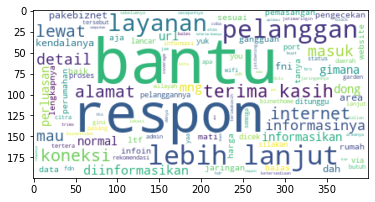

In [37]:
# generate and show the word cloud

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# dataset
corpus = cleaned_dataset.loc[data['isp']=='biznet']['tweet'].tolist()

corpus_str = ' '.join(map(str, corpus))
stop_factory = StopWordRemoverFactory().get_stop_words()
more_stopword = ['daring', 'online', 'nih', 'sih', 'kok', 'hi', 'mimin', 'yah', 'cek', 'https', 'di', 'dm', 'di_cbn', 'mohon',
                'mohon', 'min', 'ka','ga','hari','t','co','nya', 'halo', 'kak', 'yg', 'hai', 'kamu', 'thanks', 'rri','melalui','udah', 
                'pagi', ' <product_name>', '<user_mention>', '<provider_name>',
                'user_mention', 'product_name', 'biznet', 'yud', 'id', 'pbo', 'infokan']
my_stopwords = stop_factory + more_stopword
my_cloud = WordCloud(background_color='white', stopwords=my_stopwords).generate(corpus_str)
plt.imshow(my_cloud, interpolation='bilinear')